In [1]:
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch.nn.functional as F

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import datetime
import random, re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Check device 
# Get the GPU device name if available.
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))

    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 2
We will use the GPU: GeForce RTX 2080 Ti


In [ ]:
#!git clone https://github.com/mfliou/nlp_covid

In [4]:
# Read the data
train = pd.read_csv('./nlp_covid/data/covid_train.tsv',sep='\t')
train = train.rename(columns={'Label': 'pre-Label'})

valid = pd.read_csv('./nlp_covid/data/covid_valid.tsv', sep='\t', names=['Id', 'Text', 'pre-Label'])

test = pd.read_csv('./nlp_covid/data/covid_test.tsv',sep='\t', names=['Id', 'Text', 'pre-Label'])

train['Label'] = train['pre-Label'].apply(lambda x: 1 if x == 'INFORMATIVE' else 0)
valid['Label'] = valid['pre-Label'].apply(lambda x: 1 if x == 'INFORMATIVE' else 0)
test['Label'] = test['pre-Label'].apply(lambda x: 1 if x == 'INFORMATIVE' else 0)

train = train.drop('pre-Label', axis = 1)
test = test.drop('pre-Label', axis = 1)
valid = valid.drop('pre-Label', axis = 1)

pd.set_option('display.max_colwidth', 150)


print(train.info())
print(valid.info())
print(test.info())
print()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6936 entries, 0 to 6935
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      6936 non-null   int64 
 1   Text    6936 non-null   object
 2   Label   6936 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 162.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      1000 non-null   int64 
 1   Text    1000 non-null   object
 2   Label   1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      2000 non-null   int64 
 1   Text    2000 non-null   object
 2   Label   2000 non-null   int64 
dtypes: int64(2), object(1)
me

,Id,Text,Label
0,1241490299215634434,Official death toll from #covid19 in the United Kingdom is now GREATER than: Germany + Poland + Switzerland + Austria + Portugal + Greece + Sweden...,1
1,1245916400981381130,"Dearest Mr. President @USER 1,169 coronavirus deaths in the US in 24 hours (?) Covid19 pandemic is an international crime from China - not a natur...",1
2,1241132432402849793,"Latest Updates March 20 ⚠️5274 new cases and 38 new deaths in the United States Illinois: Governo Pritzker issues ""stay at home"" order for all res...",1
3,1236107253666607104,"真把公主不当干部 BREAKING: 21 people on Grand Princess cruise ship docked off the California coast tested positive for coronavirus, including 19 crew memb...",1
4,1239673817552879619,OKLAHOMA CITY — The State Department of Education announced Monday the closure of all K-12 public schools statewide until at least April 6 as the ...,0


In [5]:
valid.head()

,Id,Text,Label
0,1241728922192142336,"For those saying Pakistan isn’t Italy; After 3 weeks of the first confirmed case, Pakistan has a higher #Coronavirus growth rate than Italy. Exper...",0
1,1235713405992030209,"Second case DR 🇩🇴 The Canadian woman has not been identified, however they indicated that she is 70 years old and that she was staying with her hu...",1
2,1245941302367305728,Kill Chain: the cyber war on America's elections is a MUST SEE documentary for everyone who uses computers. HTTPURL As of 4/3/20 @USER @USER will ...,0
3,1245913002840391681,Town hosts FIRST #Virtual #TownCouncil meeting via @USER This technology was implemented due to #socialdistancing orders and FL EO 20-69 allowing ...,0
4,1240543259299987457,Report suggested that the actual number of undiagnosed Coronavirus positive cases in the country may be five 20 times than the official figure at ...,0


In [6]:
test.head()

,Id,Text,Label
0,1235770448966754309,"@USER PA hospitals don’t have the capacity. Latest from our local hospital is they will only test those with symptoms who returned from China, Ita...",0
1,1235748200742416384,Coronavirus outbreak: Intel employee in Bengaluru may be discharged today. Follow LIVE updates here: HTTPURL,1
2,1236129620363100161,Trump is trying to BS his way through the coronavirus outbreak. ⁦@USER brings together good evidence and comparisons here that suggest Trump is mo...,0
3,1241191765195001857,@USER How dramatically could we slow down this #Coronavirus from spreading if literally every american wore a mask for 2-3 weeks? I think it would...,0
4,1245182515213676546,"An Instagram post from comedienne Amy Schumer showed noisemaking and applause coming from buildings at around 7 pm, which is when shift changes oc...",0


In [7]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train.shape[0]))
print('Number of validation sentences: {:,}\n'.format(valid.shape[0]))
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

Number of training sentences: 6,936

Number of validation sentences: 1,000

Number of test sentences: 2,000



In [8]:
def clean_text(text):
    
    text = text.lower() #lowercase
    
    text = re.sub(r'[!]+','!',text)
    text = re.sub(r'[?]+','?',text)
    text = re.sub(r'[.]+','.',text)
    text = re.sub(r"'","",text)
    text = re.sub('\s+', '', text).strip() # Remove and double spaces
    text = re.sub(r'&amp;?',r'and', text) # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text) # Remove URLs
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+','',text) #remove some puncts (except . ! # ?)
    
    return text

#train['text'] = train['text'].apply(clean_text)
#test['text'] = test['text'].apply(clean_text)

train.head()

,Id,Text,Label
0,1241490299215634434,Official death toll from #covid19 in the United Kingdom is now GREATER than: Germany + Poland + Switzerland + Austria + Portugal + Greece + Sweden...,1
1,1245916400981381130,"Dearest Mr. President @USER 1,169 coronavirus deaths in the US in 24 hours (?) Covid19 pandemic is an international crime from China - not a natur...",1
2,1241132432402849793,"Latest Updates March 20 ⚠️5274 new cases and 38 new deaths in the United States Illinois: Governo Pritzker issues ""stay at home"" order for all res...",1
3,1236107253666607104,"真把公主不当干部 BREAKING: 21 people on Grand Princess cruise ship docked off the California coast tested positive for coronavirus, including 19 crew memb...",1
4,1239673817552879619,OKLAHOMA CITY — The State Department of Education announced Monday the closure of all K-12 public schools statewide until at least April 6 as the ...,0


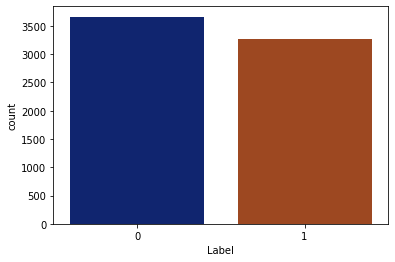

Number of informative and uninformative tweets contained in the train dataset:
0    3663
1    3273
Name: Label, dtype: int64


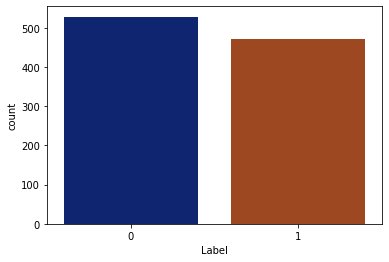

Number of informative and uninformative tweets contained in the valid dataset:
0    528
1    472
Name: Label, dtype: int64


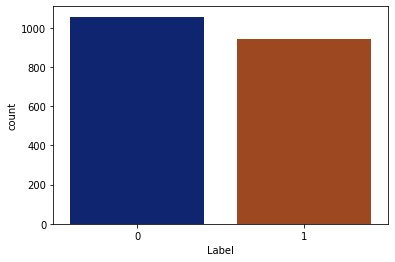

Number of informative and uninformative tweets contained in the test dataset:
0    1056
1     944
Name: Label, dtype: int64


In [9]:
# Plot count of true and false tweets in the train set
sns.countplot(x="Label", data=train, palette="dark", linewidth=5)
plt.show()

print('Number of informative and uninformative tweets contained in the train dataset:')
print(train['Label'].value_counts())

sns.countplot(x="Label", data=valid, palette="dark", linewidth=5)
plt.show()

print('Number of informative and uninformative tweets contained in the valid dataset:')
print(valid['Label'].value_counts())

sns.countplot(x="Label", data=test, palette="dark", linewidth=5)
plt.show()

print('Number of informative and uninformative tweets contained in the test dataset:')
print(test['Label'].value_counts())

In [10]:
# Get the lists of sentences and their labels.
train_sentences = train.Text.values
train_labels = train.Label.values

valid_sentences = valid.Text.values
valid_labels = valid.Label.values

test_sentences = test.Text.values
test_labels = test.Label.values

# Load the BERT tokenizer.
#To feed our text to BERT, it must be split into tokens, and then these tokens must be 
#mapped to their index in the tokenizer vocabulary.
#The tokenization must be performed by the tokenizer included with BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [11]:
# Print the original sentence.
print('train Original: ', train_sentences[0])
print('valid Original: ', valid_sentences[0])
print('test Original: ', test_sentences[0])

# Print the sentence split into tokens.
print('Tokenized train: ', tokenizer.tokenize(train_sentences[0]))
print('Tokenized valid: ', tokenizer.tokenize(valid_sentences[0]))
print('Tokenized test: ', tokenizer.tokenize(test_sentences[0]))

# Print the sentence mapped to token ids.
print('train Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[0])))
print('valid Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(valid_sentences[0])))
print('test Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(test_sentences[0])))


train Original:  Official death toll from #covid19 in the United Kingdom is now GREATER than: Germany + Poland + Switzerland + Austria + Portugal + Greece + Sweden + Finland + Norway + Ireland... COMBINED. UK: 67.5 Million (233 dead) Above group: 185 Million (230 dead) HTTPURL
valid Original:  For those saying Pakistan isn’t Italy; After 3 weeks of the first confirmed case, Pakistan has a higher #Coronavirus growth rate than Italy. Experts on the issue say Italy was too slow to lockdown. Even after lockdown, it took time for it to properly have an impact. #Corona
test Original:  @USER PA hospitals don’t have the capacity. Latest from our local hospital is they will only test those with symptoms who returned from China, Italy, Iran, Japan , or South Korea in last 14 days or those who have been in contact with someone with confirmed COVID-19 in the last 14 days.
Tokenized train:  ['official', 'death', 'toll', 'from', '#', 'co', '##vid', '##19', 'in', 'the', 'united', 'kingdom', 'is', 'no

In [12]:
train_max_len = 0
valid_max_len = 0
test_max_len = 0

# Decide on a constant maximum sentence length for padding / truncating to 
# by choosing the max length of the sentences in the dataset.
for sent in train_sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  # Update the maximum sentence length.
  train_max_len = max(train_max_len, len(input_ids))

for sent in valid_sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  # Update the maximum sentence length.
  valid_max_len = max(valid_max_len, len(input_ids))

for sent in test_sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  # Update the maximum sentence length.
  test_max_len = max(test_max_len, len(input_ids))

print('train max sentence length: ', train_max_len)
print('valid max sentence length: ', valid_max_len)
print('test max sentence length: ', test_max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1104 > 512). Running this sequence through the model will result in indexing errors


train max sentence length:  1461
valid max sentence length:  99
test max sentence length:  114


In [13]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []
train_attention_masks = []
valid_input_ids = []
valid_attention_masks = []

# For every sentence...
for sent in train_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    train_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])


# For every sentence...
for sent in valid_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    valid_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    valid_attention_masks.append(encoded_dict['attention_mask'])


# Convert the lists into tensors.
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)

valid_input_ids = torch.cat(valid_input_ids, dim=0)
valid_attention_masks = torch.cat(valid_attention_masks, dim=0)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

# Print sentence 0, now as a list of IDs.
print('train Original sentence: ', train_sentences[0])
print('train Token IDs list:', train_input_ids[0])

print('validation Original sentence: ', valid_sentences[0])
print('validation Token IDs list:', valid_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/boney/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


train Original sentence:  Official death toll from #covid19 in the United Kingdom is now GREATER than: Germany + Poland + Switzerland + Austria + Portugal + Greece + Sweden + Finland + Norway + Ireland... COMBINED. UK: 67.5 Million (233 dead) Above group: 185 Million (230 dead) HTTPURL
train Token IDs list: tensor([  101,  2880,  2331,  9565,  2013,  1001,  2522, 17258, 16147,  1999,
         1996,  2142,  2983,  2003,  2085,  3618,  2084,  1024,  2762,  1009,
         3735,  1009,  5288,  1009,  5118,  1009,  5978,  1009,  5483,  1009,
         4701,  1009,  6435,  1009,  5120,  1009,  3163,  1012,  1012,  1012,
         4117,  1012,  2866,  1024,  6163,  1012,  1019,  2454,  1006, 22115,
         2757,  1007,  2682,  2177,  1024, 15376,  2454,  1006, 11816,  2757,
         1007,  8299,  3126,   102])
validation Original sentence:  For those saying Pakistan isn’t Italy; After 3 weeks of the first confirmed case, Pakistan has a higher #Coronavirus growth rate than Italy. Experts on the

# Electra

In [14]:
import re
import torch
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW
import torch
from sklearn.metrics import classification_report
import random
import time
import datetime
import numpy as np
import pandas as pd
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

In [15]:
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


We will use the GPU: GeForce RTX 2080 Ti


In [26]:
train = train.rename(columns={'Label': 'target'})
train = train.rename(columns={'Id': 'id'})
train = train.rename(columns={'Text': 'text'})

valid = valid.rename(columns={'Label': 'target'})
valid = valid.rename(columns={'Id': 'id'})
valid = valid.rename(columns={'Text': 'text'})

test = test.rename(columns={'Label': 'target'})
test = test.rename(columns={'Id': 'id'})
test = test.rename(columns={'Text': 'text'})

frames = [train, valid]
df_train= pd.concat(frames)
df_test= test

In [27]:
def preprocess(text):
    text=text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    text = re.sub(r"(?:\@)\w+", '', text)
    text=text.encode("ascii",errors="ignore").decode()
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    text=" ".join(text.split())
    return text
df_train['text'] = df_train['text'].apply(preprocess)
df_test['text'] = df_test['text'].apply(preprocess)
df_train=df_train[df_train["text"]!='']


In [28]:
df_train=df_train[["text","target"]]

In [29]:
texts = df_train.text.values
labels = df_train.target.values

In [30]:
torch.cuda.empty_cache()
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2)
model.cuda()

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [31]:
indices=tokenizer.batch_encode_plus(texts,max_length=64,add_special_tokens=True, return_attention_mask=True,padding='max_length',truncation=True)
input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

In [32]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [33]:
# Converting all of our data into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [34]:
batch_size = 32

# the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [35]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [36]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [37]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [39]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # As we unpack the batch, we'll also copy each tensor to the GPU  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    50  of    199.    Elapsed: 0:00:07.
  Batch   100  of    199.    Elapsed: 0:00:14.
  Batch   150  of    199.    Elapsed: 0:00:21.
  Average training loss: 0.48
  Training epoch took: 0:00:28

======== Epoch 2 / 5 ========
Training...
  Batch    50  of    199.    Elapsed: 0:00:07.
  Batch   100  of    199.    Elapsed: 0:00:14.
  Batch   150  of    199.    Elapsed: 0:00:22.
  Average training loss: 0.24
  Training epoch took: 0:00:29

======== Epoch 3 / 5 ========
Training...
  Batch    50  of    199.    Elapsed: 0:00:07.
  Batch   100  of    199.    Elapsed: 0:00:15.
  Batch   150  of    199.    Elapsed: 0:00:22.
  Average training loss: 0.17
  Training epoch took: 0:00:30

======== Epoch 4 / 5 ========
Training...
  Batch    50  of    199.    Elapsed: 0:00:08.
  Batch   100  of    199.    Elapsed: 0:00:15.
  Batch   150  of    199.    Elapsed: 0:00:23.
  Average training loss: 0.14
  Training epoch took: 0:00:31

======== Epoch 5 / 

In [40]:
# Validation               

print("")
print("Running Validation...")

t0 = time.time()

model.eval()

preds=[]
true=[]

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
Accuracy: 0.93
Validation took: 0:00:02


# Electra - Predictions

In [47]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []
test_attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

test_labels = torch.tensor(test_labels)

# Print sentence 0, now as a list of IDs.
print('test Original sentence: ', test_sentences[0])
print('test Token IDs list:', test_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Number of test sentences: 2,000

test Original sentence:  @USER PA hospitals don’t have the capacity. Latest from our local hospital is they will only test those with symptoms who returned from China, Italy, Iran, Japan , or South Korea in last 14 days or those who have been in contact with someone with confirmed COVID-19 in the last 14 days.
test Token IDs list: tensor([  101,  1030,  5310,  6643,  8323,  2123,  1521,  1056,  2031,  1996,
         3977,  1012,  6745,  2013,  2256,  2334,  2902,  2003,  2027,  2097,
         2069,  3231,  2216,  2007,  8030,  2040,  2513,  2013,  2859,  1010,
         3304,  1010,  4238,  1010,  2900,  1010,  2030,  2148,  4420,  1999,
         2197,  2403,  2420,  2030,  2216,  2040,  2031,  2042,  1999,  3967,
         2007,  2619,  2007,  4484,  2522, 17258,  1011,  2539,  1999,  1996,
         2197,  2403,  2420,   102])


In [48]:
# Set test_data_set, the batch size and create DataLoader
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

batch_size = 32 # same as in training: 32  

test_dataloader = DataLoader(
            test_dataset, # The test samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [52]:
print("")
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

test_stats = []

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

# Tracking variables 
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0

# Evaluate data for one epoch
for batch in test_dataloader:

    # Unpack this training batch from our dataloader. 
    # As we unpack the batch, I'll also copy each tensor to the GPU using the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        (loss, logits) = model(b_input_ids, 
                               token_type_ids=None, 
                               attention_mask=b_input_mask,
                               labels=b_labels,
                               return_dict=False)

    # Accumulate the validation loss.
    total_eval_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)


# Report the final accuracy for this validation run.
avg_test_accuracy = total_eval_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

# Calculate the average loss over all of the batches.
avg_test_loss = total_eval_loss / len(test_dataloader)

# Measure how long the validation run took.
test_time = format_time(time.time() - t0)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took  {:} time".format(test_time))

# Record all statistics from this epoch.
#    test_stats.append(
#        {
#            'Test. Loss': avg_val_loss,
#            'Test. Accur.': avg_val_accuracy,
#            'Test time': test_time
#        }
#    )


Predicting labels for 2,000 test sentences...
  Accuracy: 0.87
  Test Loss: 0.38
  Test took  0:00:03 time
